# Phase 2 - Machine Learning with H2O.ai

##### Build - 4 new ML models using H2O.ai framework
- GLM - Generalized Linear Model
- Random Forest
- GBM
- XGBoost

## Recap
#### Info about model evaluation - accuracy metric vs recall
- The global metric accuracy will be used to evaluate the models between all frameworks (xgb, lgbm, sklearn, h2o.ai and Apache Spark)

#### The last notebook build ml models using python will provide some additional techniques, such as:
- Unbalanced classification and class weight
- Smote technique for oversampling the training dataset
- Standard Scale vs. default data and 
- Finally, exchange the global metric accuracy and use recall metric < recall or Sensitivity or True positive rate (TPR) > 
<br> Recall metric is a better metric than accuracy to evaluate this type of scenario (customer churn)

##### Additional info: http://docs.h2o.ai/h2o/latest-stable/h2o-docs/performance-and-prediction.html

#### Starting process...

In [2]:
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split

## Metrics - Classification
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

## H2O
import h2o

## ML Models
from h2o.estimators import (H2OGeneralizedLinearEstimator, H2OGradientBoostingEstimator, 
                            H2ORandomForestEstimator, H2OXGBoostEstimator)


### H2O - connection to h2o cluster

In [3]:
## connect to h2o cluster and remove all object
h2o.connect(ip='192.168.56.102')
h2o.remove_all()

Connecting to H2O server at http://192.168.56.102:54321 ... successful.


H2O cluster uptime:,1 hour 22 mins
H2O cluster timezone:,America/Sao_Paulo
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.3
H2O cluster version age:,7 months and 22 days !!!
H2O cluster name:,userds1
H2O cluster total nodes:,1
H2O cluster free memory:,5.746 Gb
H2O cluster total cores:,1
H2O cluster allowed cores:,1
H2O cluster status:,"locked, healthy"


### Load and prepare the dataset to build ML models

In [4]:
## Load dataset
df = pd.read_csv('../data/WA_Fn-UseC_-Telco-Customer-Churn.csv')

## Filter columns and set values
df.loc[(df.tenure==0) & (df.TotalCharges == ' '), ['TotalCharges', 'tenure']] = 0
df['TotalCharges'] = df['TotalCharges'].astype('float')

target = 'Churn'
current_features = ['tenure', 'MonthlyCharges', 'TotalCharges', 'gender', 'PaymentMethod' , 'Churn', 'Contract']

df = df[current_features]
df.head(3)


,tenure,MonthlyCharges,TotalCharges,gender,PaymentMethod,Churn,Contract
0,1,29.85,29.85,Female,Electronic check,No,Month-to-month
1,34,56.95,1889.50,Male,Mailed check,No,One year
2,2,53.85,108.15,Male,Mailed check,Yes,Month-to-month


#### Load dataset into H2O cluster

In [5]:
target = 'Churn'
features = df.columns.to_list()
features.remove(target)

X = df[features]
y = df[target]

SEED = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=SEED)

## Label Encode - will be used later to evaluate model performance
target_1_0 = lambda x: ['No', 'Yes'].index(x)
y_true_test = y_test.apply(target_1_0).values

train_X = X_train.copy()
train_X[target] = y_train

test_X = X_test.copy()
test_X[target] = y_test

## Convert to h2o Frame
train_h2o = h2o.H2OFrame(train_X, destination_frame='train.hex')
test_h2o = h2o.H2OFrame(test_X, destination_frame='test.hex')

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


## H2O - Build Machine Learning Models

#### H2O - RANDOM FOREST
- Accuracy: 71,78%

In [6]:
## Random Forest
model_rf = H2ORandomForestEstimator(seed = SEED)
model_rf.train(
    x = features,
    y = target,
    training_frame = train_h2o,
    model_id = 'fit_rf.model'
)
ypred_RF_df = model_rf.predict(test_h2o).as_data_frame()
# model_rf.model_performance()

print('Random Forest')
y_pred_RF = ypred_RF_df['predict'].apply(target_1_0).values

# print_confusion_matrix(y_true, y_pred)
print('Accuracy score: ', accuracy_score(y_true_test, y_pred_RF))

drf Model Build progress: |███████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
Random Forest
Accuracy score:  0.7178494623655914


#### H2O GBM 
- Accuracy: 77,07%

In [7]:
model_gbm = H2OGradientBoostingEstimator(seed = SEED)
model_gbm.train(
    x = features,
    y = target,
    training_frame = train_h2o,
    model_id = 'fit_gbm.model'
)
# model_gbm.model_performance()

ypred_GBM_df = model_gbm.predict(test_h2o).as_data_frame()
y_pred = ypred_GBM_df['predict'].copy().apply(target_1_0).values


print('GBM')
# print_confusion_matrix(y_true, y_pred)
print('Accuracy score: ', accuracy_score(y_true_test, y_pred))

gbm Model Build progress: |███████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
GBM
Accuracy score:  0.770752688172043


#### H2O - GLM (generalized linear model)
- Accuracy: 76,64%

In [8]:
model_glm = H2OGeneralizedLinearEstimator(seed = SEED, family='binomial')
model_glm.train(
    x = features,
    y = target,
    training_frame = train_h2o,
    model_id = 'fit_glm.model'
)
# model_glm.model_performance()
ypred_GLM_df = model_glm.predict(test_h2o).as_data_frame()
y_pred = ypred_GLM_df['predict'].copy().apply(target_1_0).values

print('GLM')
# print_confusion_matrix(y_true, y_pred)
print('Accuracy score: ', accuracy_score(y_true_test, y_pred))


glm Model Build progress: |███████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
GLM
Accuracy score:  0.7664516129032258


#### H2O - XGB
- Accuracy: 79,18%

In [9]:
model_xgb = H2OXGBoostEstimator(seed = SEED)
model_xgb.train(
    x = features,
    y = target,
    training_frame = train_h2o,
    model_id = 'fit_xgb.model'
)
# model_xgb.model_performance()
ypred_XGB_df = model_xgb.predict(test_h2o).as_data_frame()
y_pred = ypred_XGB_df['predict'].copy().apply(target_1_0).values

print('XGB')
# print_confusion_matrix(y_true, y_pred)
print('Accuracy score: ', accuracy_score(y_true_test, y_pred))


xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
XGB
Accuracy score:  0.7918279569892474


### Export model
- H2O xgb have the highest accuracy score

In [10]:
## H2O export model
export_model_path = h2o.save_model(model=model_xgb, path="./ML_models/model_xgb_v1/", force=True)
print('Export done!')

Export done!


### Load the model and run prediction again to test the results

In [11]:
h2o_model_xgb = h2o.load_model(export_model_path)

# model_xgb.model_performance()
ypred_XGB_df = h2o_model_xgb.predict(test_h2o).as_data_frame()
y_pred = ypred_XGB_df['predict'].copy().apply(target_1_0).values

print('XGB')
# print_confusion_matrix(y_true, y_pred)
print('Accuracy score: ', accuracy_score(y_true_test, y_pred))

xgboost prediction progress: |████████████████████████████████████████████| 100%
XGB
Accuracy score:  0.7918279569892474


### Evaluation report
#### Confusion matrix - associated with XGB
- Accuracy: 79,18%

### Plot Feature importance - H2O - xgb

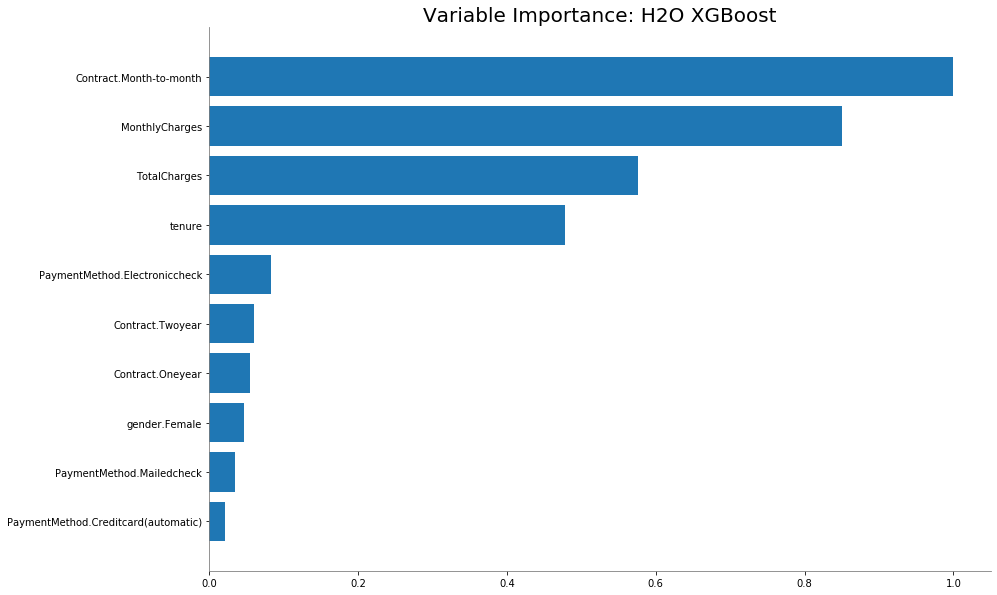

In [13]:
model_xgb.varimp_plot()

## Summary with h2o
- The xgb achieved the best accuracy and was exported to be used later

#### The most important features, characteristics that influence customer churn are:
- Contract_Month-to_Month
- MonthlyCharges
- TotalCharges and
- tenure

### Let´s move on with ML model built using Apache Spark framework in the next notebook

In [16]:
# !jupyter nbconvert --to html Phase_2_Build_ML_models_with_Python_3x6_h2o_ai.ipynb